In [150]:
import os 
import numpy as np 
import settings as s
from Recording import Recording

import os
import umap
import scipy.io as sio
import numpy as np
import h5py

import matplotlib
from rich import print
from rich.progress import track
from rich.traceback import install 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns

from sklearn import svm
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut, RepeatedKFold, cross_val_predict
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

paths = s.paths()
params = s.params()

# Keep in mind that it is here
import warnings
warnings.filterwarnings('ignore')

In [151]:
# Load electrophy recordings
recs = []
main_folder = '/home/anverdie/Documents/Electrophy/To_analyze'
for folder in os.listdir(main_folder):
    cp = os.path.join(main_folder, folder)
    print('Analyzing {} ...'.format(folder))
    rec = Recording(cp, os.path.join(cp, 'SoundInfo.mat'), name=folder)
    rec.select_data_quality(quality='good')
    rec.ttl_alignment(multi=False)
    recs.append(rec)

rec = np.sum(recs)

Analyzing 23_11_2021_2 ...

Analyzing 23_11_2021_1 ...

Analyzing 09_11_2021_1 ...

Analyzing 08_11_2021_2 ...

Analyzing 09_11_2021_2 ...

Analyzing 08_11_2021_1 ...

In [152]:
def compute_svm(X, y):

    scores = []
    X, y = shuffle(X, y)
    clf = svm.SVC(kernel='linear')
    scores = cross_val_score(clf, X, y, cv=5)


    ########## Need to make sure that data is shuffled
    #scores = cross_val_score(clf, X, y, cv=5)
    return scores

In [153]:
def svm_preformance(rec):
    for i, t in enumerate([params.task1, params.task2, params.task3, params.task4]):
        scores = []
        for p in track(np.arange(0, 1000, 50), description='Compute SVM for each task ...'):
            pop_vectors = rec.complete_vectors(0, p)

            X = np.array([pop_vectors[stim][p] for stim in t for p in pop_vectors[stim]])
            if i < 2:
                y = np.array([0 if i < 8 else 1 for i, stim in enumerate(t) for p in pop_vectors[stim]])
            elif i == 2:
                y = params.y_task3
            elif i == 3:
                y = params.y_task4

            score = compute_svm(X, y)
            scores.append([np.mean(score), np.std(score)])

        scores = np.array(scores).reshape(-1, 2)

        plt.errorbar(np.arange(0, 1000, 50), scores[:, 0], label='Task {}'.format(i + 1))

    plt.legend()
    plt.savefig('performance_svm_population.png')
    plt.show()

In [155]:
def psychocurve1(rec, pb=0, pa=1000, timebin=10, vec='complete'):

    colors = ['blue']
    for tidx, t in enumerate([params.task1]):
        
        if vec == 'complete': pop_vectors = rec.get_complete_vectors(pb, pa, timebin=timebin)
        if vec == 'time': pop_vectors = rec.get_timings_vectors(pb, pa, timebin=timebin)
        if vec == 'pop': pop_vectors = rec.get_population_vectors(pb, pa)


        X = np.array([pop_vectors[stim][p] for stim in t for p in pop_vectors[stim]])
        y = np.array([0 if i < 8 else 1 for i, stim in enumerate(t) for p in pop_vectors[stim]])
        
        true_classes = np.array([i for i, stim in enumerate(t) for p in pop_vectors[stim]]) + 1

        X, y, true_classes = shuffle(X, y, true_classes)
        psycos = []
        for train_index, test_index in track(RepeatedKFold(n_repeats=3).split(X), total=5*3):
            clf = svm.SVC(kernel='linear')
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            tc_train, tc_test = true_classes[train_index], true_classes[test_index]

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            correct = np.logical_not(np.logical_xor(y_pred, y_test))
            counting_vec = list(correct * tc_test)

            for i in np.unique(true_classes):
                try:
                    if i < 9:
                        psycos.append(counting_vec.count(i)/list(tc_test).count(i))
                    else:
                        psycos.append(1 - counting_vec.count(i)/list(tc_test).count(i))
                except ZeroDivisionError:
                    psycos.append(0)
    
        
        psycos = np.array(psycos).reshape(-1, 16)
        psycos = np.mean(psycos, axis=0)

        plt.plot(np.geomspace(6e3, 16e3, 16), psycos, color=colors[tidx], linewidth=2, markersize=6, marker='o')
        plt.xscale('log')
        plt.show()

In [156]:
def psychocurve2(rec, pb=0, pa=1000, timebin=10, vec='complete'):
    
    
    colors = ['forestgreen']
    for tidx, t in enumerate([params.task2]):
        
        if vec == 'complete': pop_vectors = rec.get_complete_vectors(pb, pa, timebin=timebin)
        if vec == 'time': pop_vectors = rec.get_timings_vectors(pb, pa, timebin=timebin)
        if vec == 'pop': pop_vectors = rec.get_population_vectors(pb, pa)


        X = np.array([pop_vectors[stim][p] for stim in t for p in pop_vectors[stim]])
        y = np.array([0 if i < 8 else 1 for i, stim in enumerate(t) for p in pop_vectors[stim]])

        true_classes = np.array([i for i, stim in enumerate(t) for p in pop_vectors[stim]]) + 1
        
        X, y, true_classes = shuffle(X, y, true_classes)
        psycos = []
        for train_index, test_index in track(RepeatedKFold(n_repeats=3).split(X), total=5*3):
            clf = svm.SVC(kernel='linear')
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            tc_train, tc_test = true_classes[train_index], true_classes[test_index]

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            correct = np.logical_not(np.logical_xor(y_pred, y_test))
            counting_vec = list(correct * tc_test)

            for i in np.unique(true_classes):
                try:
                    if i < 9:
                        psycos.append(counting_vec.count(i)/list(tc_test).count(i))
                    else:
                        psycos.append(1 - counting_vec.count(i)/list(tc_test).count(i))
                except ZeroDivisionError:
                    psycos.append(0)
    
        
        psycos = np.array(psycos).reshape(-1, 16)
        psycos = np.mean(psycos, axis=0)

        plt.plot(np.geomspace(20, 200, 16), psycos, color=colors[tidx], linewidth=2, markersize=6, marker='o')
        plt.xscale('log')
        plt.show()

In [157]:
def psychocurve3(rec, pb=0, pa=1000, timebin=10, vec='complete'):
    
    task31 = [8, 12 , 16, 20, 0, 4]
    task32 = [x + 1 for x in task31]
    task33 = [x + 1 for x in task32]
    task34 = [x + 1 for x in task33]
    
    colors = ['#faa307', '#f48c06', '#e85d04', '#dc2f02']
    legends = ['45dB', '50dB', '55dB', '60dB']
    for tidx, t in enumerate([task31, task32, task33, task34]):
        
        if vec == 'complete': pop_vectors = rec.get_complete_vectors(pb, pa, timebin=timebin)
        if vec == 'time': pop_vectors = rec.get_timings_vectors(pb, pa, timebin=timebin)
        if vec == 'pop': pop_vectors = rec.get_population_vectors(pb, pa)


        X = np.array([pop_vectors[stim][p] for stim in t for p in pop_vectors[stim]])
        y = np.array([0 if i < 3 else 1 for i, stim in enumerate(t) for p in pop_vectors[stim]])

        true_classes = np.array([i for i, stim in enumerate(t) for p in pop_vectors[stim]]) + 1

        X, y, true_classes = shuffle(X, y, true_classes)
        psycos = []
        for train_index, test_index in track(RepeatedKFold(n_repeats=3).split(X), total=5*3):
            clf = svm.SVC(kernel='linear')
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            tc_train, tc_test = true_classes[train_index], true_classes[test_index]

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            correct = np.logical_not(np.logical_xor(y_pred, y_test))
            counting_vec = list(correct * tc_test)

            for i in np.unique(true_classes):
                try:
                    if i < 4:
                        psycos.append(counting_vec.count(i)/list(tc_test).count(i))
                    else:
                        psycos.append(1 - counting_vec.count(i)/list(tc_test).count(i))
                except ZeroDivisionError:
                    psycos.append(0)
    
        psycos = np.array(psycos).reshape(-1, 6)
        psycos = np.mean(psycos, axis=0)

        plt.plot(np.geomspace(20, 200, 6), psycos, color=colors[tidx], linewidth=2, markersize=6, marker='o')
        plt.xscale('log')
        plt.legend()
    plt.show()
        

In [158]:
def psychocurve4(rec, pb=0, pa=1000, timebin=10, vec='complete'):
    colors = ['purple']
    for tidx, t in enumerate([params.task4]):
        
        if vec == 'complete': pop_vectors = rec.get_complete_vectors(pb, pa, timebin=timebin)
        if vec == 'time': pop_vectors = rec.get_timings_vectors(pb, pa, timebin=timebin)
        if vec == 'pop': pop_vectors = rec.get_population_vectors(pb, pa)


        X = np.array([pop_vectors[stim][p] for stim in t for p in pop_vectors[stim]])
        y = np.array([1 if i == 0 else 0 for i, stim in enumerate(t) for p in pop_vectors[stim]])

        true_classes = np.array([i for i, stim in enumerate(t) for p in pop_vectors[stim]]) + 1
        

        X, y, true_classes = shuffle(X, y, true_classes)
        psycos = []
        for train_index, test_index in track(LeaveOneOut().split(X), total=X.shape[0]):
            clf = svm.SVC(kernel='linear')
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            tc_train, tc_test = true_classes[train_index], true_classes[test_index]

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            correct = np.logical_not(np.logical_xor(y_pred, y_test))
            counting_vec = list(correct * tc_test)

            for i in np.unique(true_classes):
                try:
                    if i > 1:
                        psycos.append(counting_vec.count(i)/list(tc_test).count(i))
                    else:
                        psycos.append(1 - counting_vec.count(i)/list(tc_test).count(i))
                except ZeroDivisionError:
                    psycos.append(0)
        
        psycos = np.array(psycos).reshape(-1, 6)
        psycos = np.mean(psycos, axis=0)

        plt.plot([0, 2, 4, 6, 8, 10], psycos, color=colors[tidx], linewidth=2, markersize=6, marker='o')
        plt.show()
        

/home/anverdie/Documents/Code/Utilities/Electrophy_Analysis/Recording.py:190: RuntimeWarning: invalid value encountered in true_divide
  pvec = np.nan_to_num((pvec - np.min(pvec))/np.max(pvec))


Output()

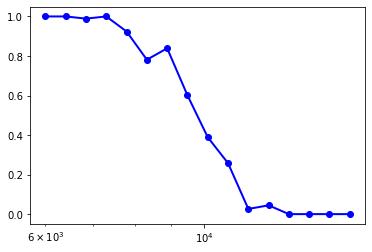

/home/anverdie/Documents/Code/Utilities/Electrophy_Analysis/Recording.py:190: RuntimeWarning: invalid value encountered in true_divide
  pvec = np.nan_to_num((pvec - np.min(pvec))/np.max(pvec))


In [ ]:
psychocurve1(rec, pb=0, pa=1000,timebin=10, vec='complete')
psychocurve2(rec, pb=0, pa=1000,timebin=10, vec='complete')
psychocurve3(rec, pb=0, pa=1000,timebin=10, vec='complete')
psychocurve4(rec, pb=0, pa=1000,timebin=10, vec='complete')